In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download dansbecker/cityscapes-image-pairs

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cityscapes-image-pairs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [47]:
!unzip /content/cityscapes-image-pairs.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: cityscapes_data/cityscapes_data/train/2754.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2765.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2766.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2767.jpg  
  inflatin

ValueError: ignored

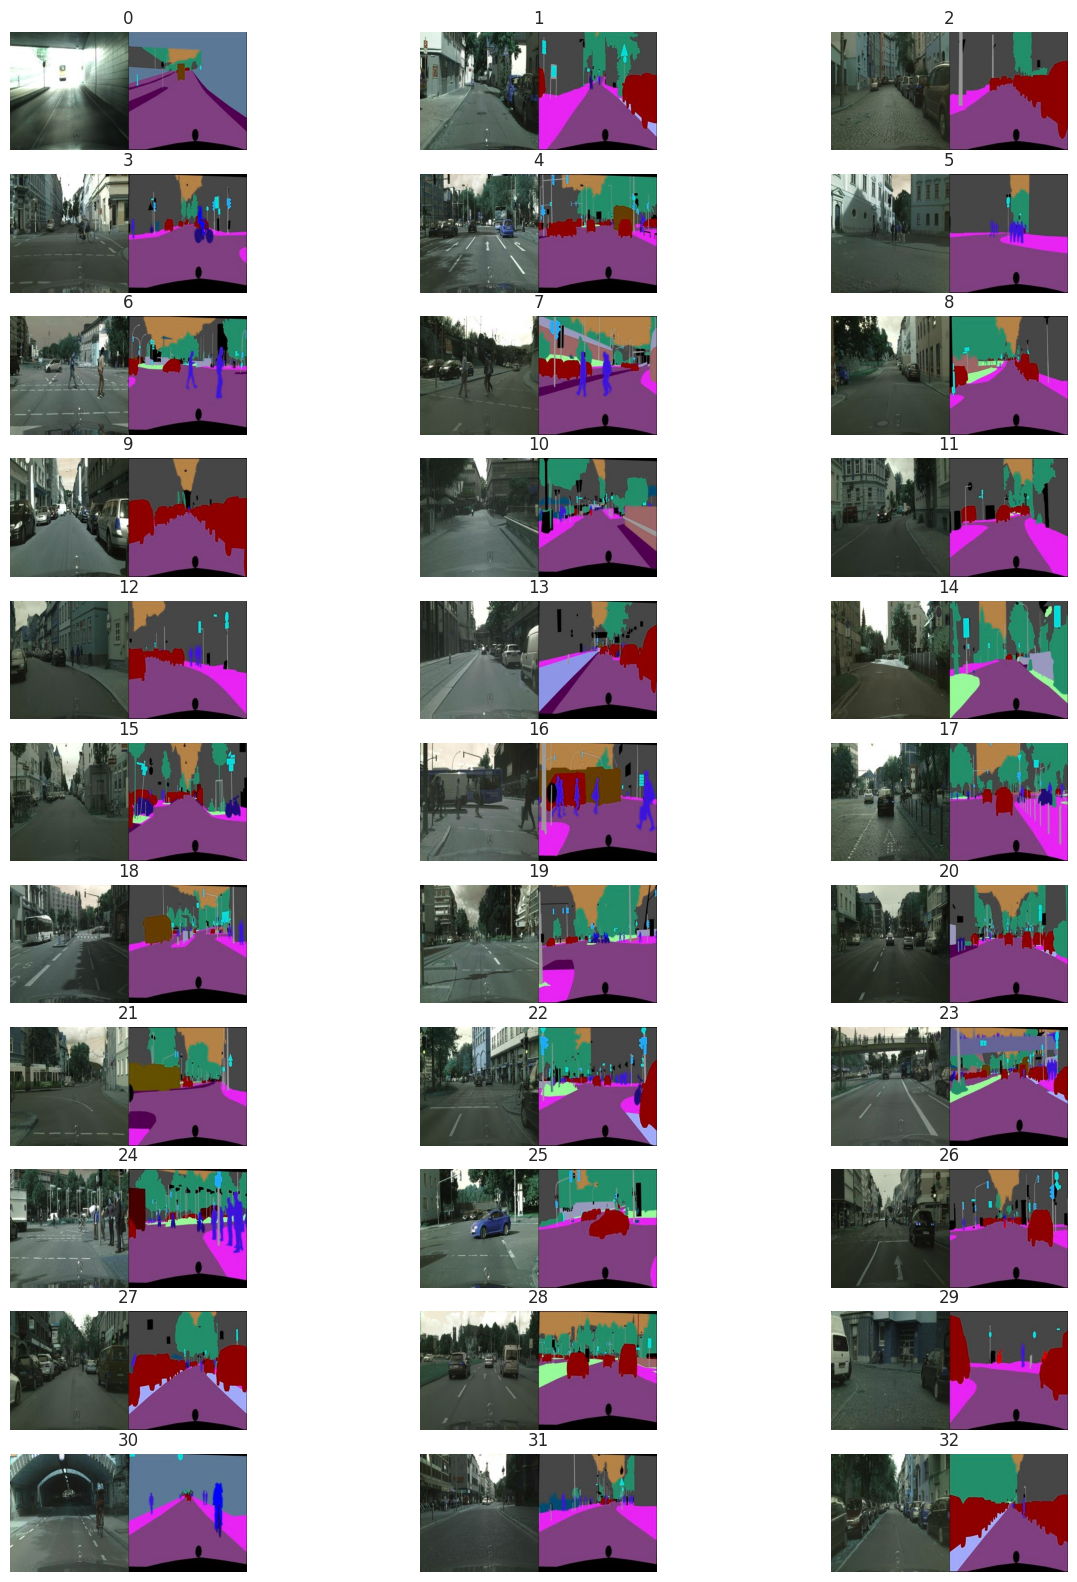

In [133]:
import glob
import cv2
import matplotlib.pyplot as plt

binarized_images = {}

id=0
for image in glob.glob('/content/cityscapes_data/cityscapes_data/train/*.jpg'):
  binarized_images[id] = cv2.imread(image)
  id=id+1

subplot = 0
plt.rcParams["figure.figsize"] = (15,20) 
for key, value in binarized_images.items():
  plt.subplot(11,3,subplot+1)
  plt.axis('off')
  plt.title(key)
  plt.imshow(value)
  subplot +=1

In [134]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from PIL import Image
import os
import warnings

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]
df = pd.DataFrame(labels)
df.head(20)

,name,id,trainId,category,categoryId,hasInstances,ignoreInEval,color
0,unlabeled,0,255,void,0,False,True,"(0, 0, 0)"
1,ego vehicle,1,255,void,0,False,True,"(0, 0, 0)"
2,rectification border,2,255,void,0,False,True,"(0, 0, 0)"
3,out of roi,3,255,void,0,False,True,"(0, 0, 0)"
4,static,4,255,void,0,False,True,"(0, 0, 0)"
5,dynamic,5,255,void,0,False,True,"(111, 74, 0)"
6,ground,6,255,void,0,False,True,"(81, 0, 81)"
7,road,7,0,ground,1,False,False,"(128, 64, 128)"
8,sidewalk,8,1,ground,1,False,False,"(244, 35, 232)"
9,parking,9,255,ground,1,False,True,"(250, 170, 160)"


## BAR CHART

([<matplotlib.axis.XTick at 0x7f78d4c67460>,
 [Text(0, 0, 'unlabeled'),
  Text(1, 0, 'ego vehicle'),
  Text(2, 0, 'rectification border'),
  Text(3, 0, 'out of roi'),
  Text(4, 0, 'static'),
  Text(5, 0, 'dynamic'),
  Text(6, 0, 'ground'),
  Text(7, 0, 'road'),
  Text(8, 0, 'sidewalk'),
  Text(9, 0, 'parking'),
  Text(10, 0, 'rail track'),
  Text(11, 0, 'building'),
  Text(12, 0, 'wall'),
  Text(13, 0, 'fence'),
  Text(14, 0, 'guard rail'),
  Text(15, 0, 'bridge'),
  Text(16, 0, 'tunnel'),
  Text(17, 0, 'pole'),
  Text(18, 0, 'polegroup'),
  Text(19, 0, 'traffic light'),
  Text(20, 0, 'traffic sign'),
  Text(21, 0, 'vegetation'),
  Text(22, 0, 'terrain'),
  Text(23, 0, 'sky'),
  Text(24, 0, 'person'),
  Text(25, 0, 'rider'),
  Text(26, 0, 'car'),
  Text(27, 0, 'truck'),
  Text(28, 0, 'bus'),
  Text(29, 0, 'caravan'),
  Text(30, 0, 'trailer'),
  Text(31, 0, 'train'),
  Text(32, 0, 'motorcycle'),
  Text(33, 0, 'bicycle'),
  Text(34, 0, 'license plate')])

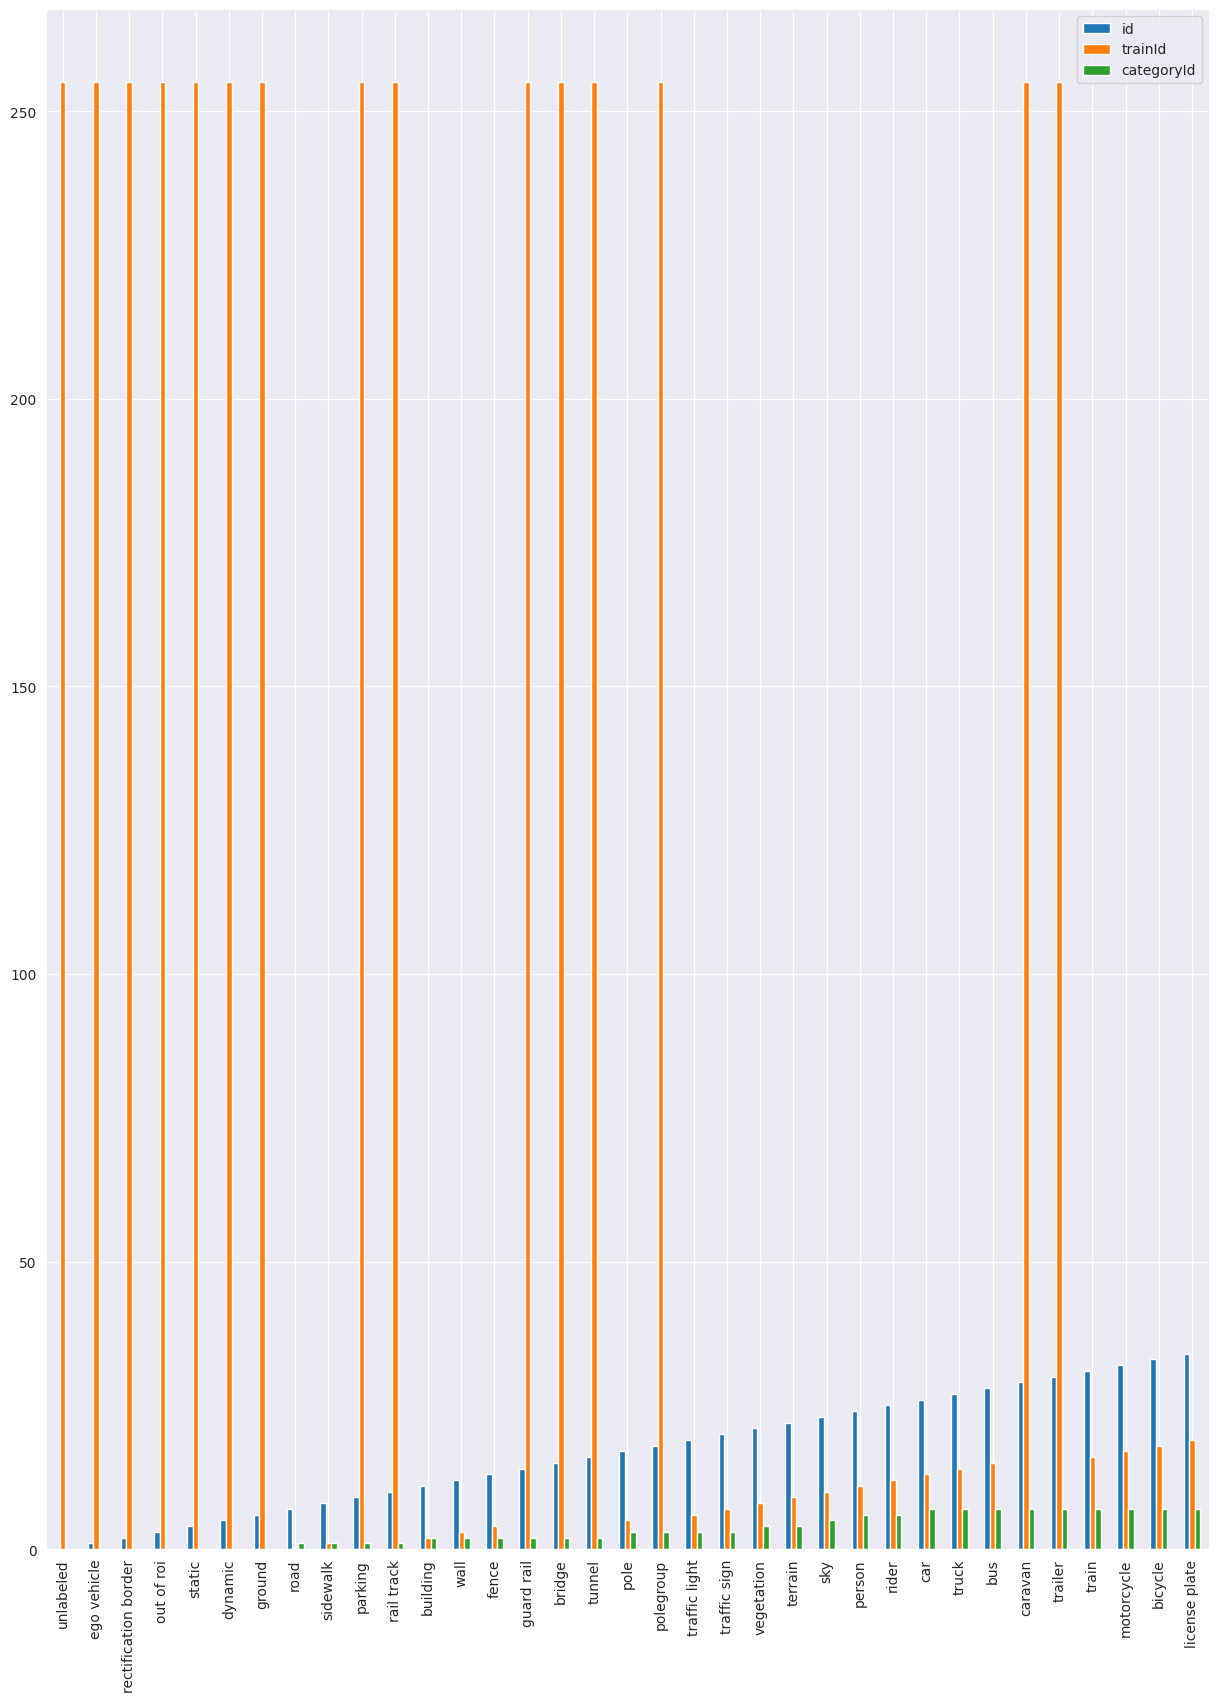

In [135]:
df.plot(xticks=df.index, kind = 'bar')
plt.xticks(df.index, df['name'])

([<matplotlib.axis.YTick at 0x7f78d4a37fa0>,
 [Text(0, 0, 'unlabeled'),
  Text(0, 1, 'ego vehicle'),
  Text(0, 2, 'rectification border'),
  Text(0, 3, 'out of roi'),
  Text(0, 4, 'static'),
  Text(0, 5, 'dynamic'),
  Text(0, 6, 'ground'),
  Text(0, 7, 'road'),
  Text(0, 8, 'sidewalk'),
  Text(0, 9, 'parking'),
  Text(0, 10, 'rail track'),
  Text(0, 11, 'building'),
  Text(0, 12, 'wall'),
  Text(0, 13, 'fence'),
  Text(0, 14, 'guard rail'),
  Text(0, 15, 'bridge'),
  Text(0, 16, 'tunnel'),
  Text(0, 17, 'pole'),
  Text(0, 18, 'polegroup'),
  Text(0, 19, 'traffic light'),
  Text(0, 20, 'traffic sign'),
  Text(0, 21, 'vegetation'),
  Text(0, 22, 'terrain'),
  Text(0, 23, 'sky'),
  Text(0, 24, 'person'),
  Text(0, 25, 'rider'),
  Text(0, 26, 'car'),
  Text(0, 27, 'truck'),
  Text(0, 28, 'bus'),
  Text(0, 29, 'caravan'),
  Text(0, 30, 'trailer'),
  Text(0, 31, 'train'),
  Text(0, 32, 'motorcycle'),
  Text(0, 33, 'bicycle'),
  Text(0, 34, 'license plate')])

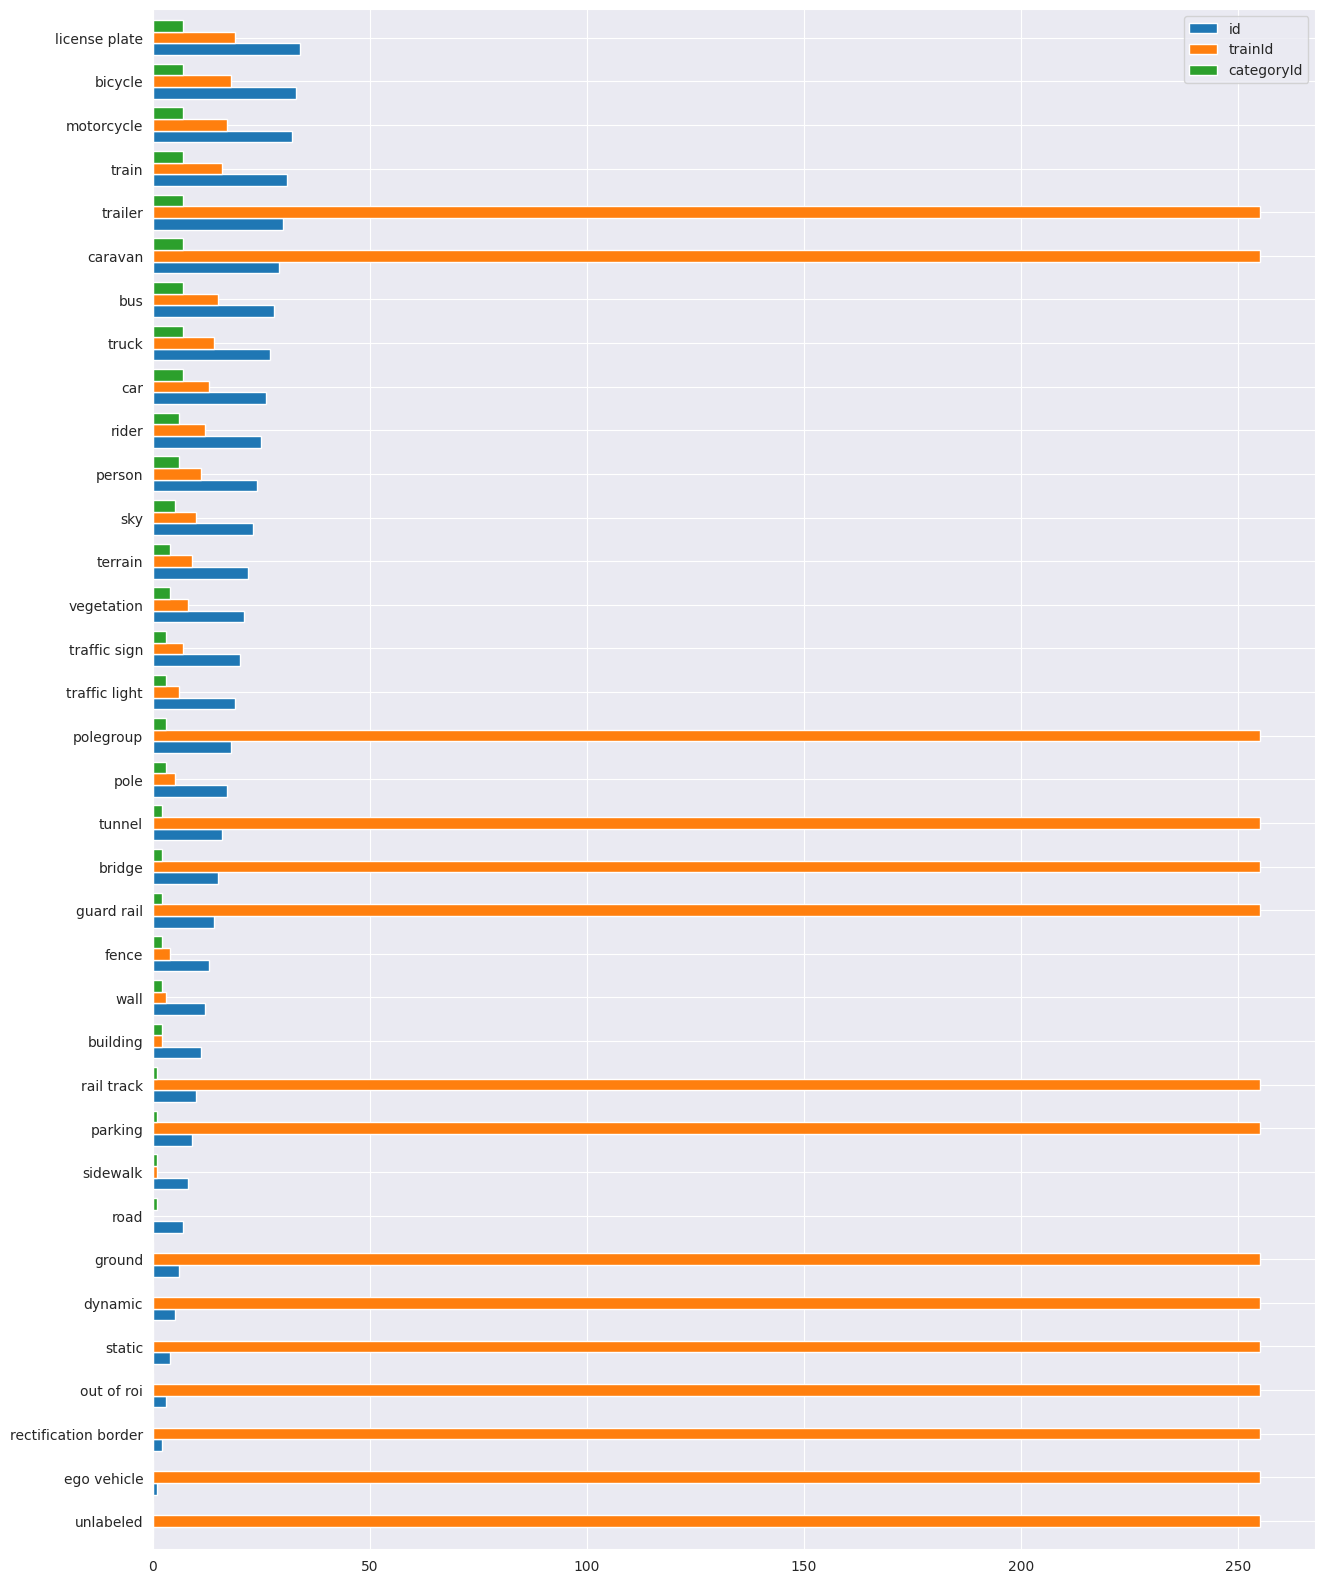

In [136]:
df.plot(yticks=df.index, kind = 'barh', width=0.8)
plt.yticks(df.index, df['name'])